In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change to the directory containing your files
%cd /content/drive/MyDrive/Colab Notebooks/Summer Research Project 2025/Fractured Entangled Representation/fer-master/fer-master/src

/content/drive/MyDrive/Colab Notebooks/Summer Research Project 2025/Fractured Entangled Representation/fer-master/fer-master/src


In [3]:
%load_ext autoreload
%autoreload 2
import os, sys
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

ModuleNotFoundError: No module named 'imp'

In [3]:
# ------------------------RUN THIS BLOCK ONLY IF YOU ARE RUNNING IN GOOGLE COLAB------------------------
! git clone https://github.com/akarshkumar0101/fer.git
#%cd fer/src
! pip install "evosax==0.1.6"

fatal: destination path 'fer' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 11.7 MB/s eta 0:00:00


In [4]:
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, repeat

import jax
import jax.numpy as jnp

from cppn import CPPN, FlattenCPPNParameters
import util

## Preprocessing the Picbreeder Genomes

Run these commands to preprocess the genomes from Picbreeder.
This involves loading the raw genome data, interpreting it as a NEAT computation graph, and then layerizing it into an Flax (Jax) MLP, as described in the paper.
Layerization means porting it into a dense MLP format, ameniable to SGD

NOTE: you do not have to run this if you don't want to, we have already put the data in this repo.

In [5]:
! python process_pb.py --zip_path="../picbreeder_genomes/skull.zip"  --save_dir="../data/picbreeder_skull"

ParameterReshaper: 5478 parameters detected for optimization.
ParameterReshaper: 5478 parameters detected for optimization.


Great! Let's take a look at the outputs of the CPPNs.

genome: skull, arch: 12;cache:15,gaussian:4,identity:2,sin:1
ParameterReshaper: 5478 parameters detected for optimization.


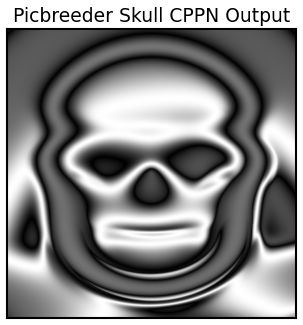

In [6]:
plt.figure(figsize=(20, 5), dpi=75)
iplt = 0
for genome in ["skull"]:
    iplt += 1
    plt.subplot(1, 3, iplt)
    save_dir = f"../data/picbreeder_{genome}"
    arch_ = util.load_pkl(save_dir, "arch")
    print(f"genome: {genome}, arch: {arch_}")
    params = util.load_pkl(save_dir, "params")
    cppn = FlattenCPPNParameters(CPPN(arch_))
    img = np.array(cppn.generate_image(params, img_size=512))
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.title(f"Picbreeder {genome.capitalize()} CPPN Output", fontsize=18)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
plt.show()

## Training SGD CPPNs to Copy Behavior

Now, run these commands to run SGD on CPPNs with the same architecture to mimic the output behavior.
We are training to match the Picbreeder output images using an MSE loss.

NOTE: you do not have to run this if you don't want to, we have already put the data in this repo.

In [24]:
#! python train_sgd.py --seed=2 --save_dir="../data/sgd_skull" --arch="12;cache:30,gaussian:8,identity:4,sin:2" --img_file="../data/picbreeder_skull/img.png" --n_iters=200000 --lr=0.003 --l2_coeff=1e-3

! python train_sgd.py --seed=2 --save_dir="../data/sgd_skull" --arch="12;cache:15,gaussian:4,identity:2,sin:1" --img_file="../data/picbreeder_skull/img.png" --n_iters=100000 --lr=0.003
#! python train_sgd.py --seed=2 --save_dir="../data/sgd_skull" --arch="12;cache:60,gaussian:4,identity:4,identity:8,sin:8" --img_file="../data/picbreeder_skull/img.png" --n_iters=100000 --lr=0.003  --l2_coeff=1e-3

UPDATED
Namespace(seed=2, save_dir='../data/sgd_skull', arch='12;cache:15,gaussian:4,identity:2,sin:1', img_file='../data/picbreeder_skull/img.png', n_iters=100000, lr=0.003, init_scale='default', l2_coeff=0.0, lambda_grad=0.0)
ParameterReshaper: 5478 parameters detected for optimization.
 13% 126/1000 [00:51<05:53,  2.47it/s, loss=0.00217]
Traceback (most recent call last):
  File "/content/drive/MyDrive/Colab Notebooks/Summer Research Project 2025/Fractured Entangled Representation/fer-master/fer-master/src/train_sgd.py", line 156, in <module>
    main(parse_args())
  File "/content/drive/MyDrive/Colab Notebooks/Summer Research Project 2025/Fractured Entangled Representation/fer-master/fer-master/src/train_sgd.py", line 135, in main
    pbar.set_postfix(loss=loss.mean().item())
                          ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/numpy/array_methods.py", line 213, in _item
    arr = core.concrete_or_error(np.asarray, self, context="Thi

Let's take a look at the loss curves!

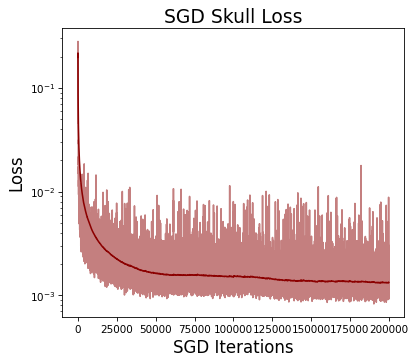

In [20]:
plt.figure(figsize=(20, 5), dpi=75)
iplt = 0
for genome in ["skull"]:
    iplt += 1
    plt.subplot(1, 3, iplt)
    save_dir = f"../data/sgd_{genome}"
    losses = util.load_pkl(save_dir, "losses")
    plt.plot(losses, c='darkred', alpha=0.5)
    losses_smoothed = pd.Series(losses).ewm(span=10000).mean()
    plt.plot(losses_smoothed, c='darkred')
    plt.yscale('log')
    plt.title(f"SGD {genome.capitalize()} Loss", fontsize=18)
    plt.xlabel("SGD Iterations", fontsize=16); plt.ylabel("Loss", fontsize=16)
plt.show()


Looks good! Now, let's take a look at the outputs of the SGD CPPNs.

ParameterReshaper: 21604 parameters detected for optimization.


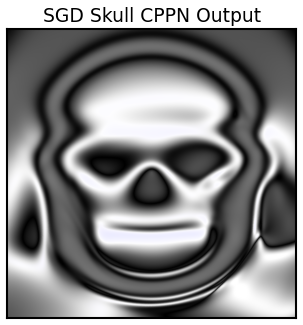

In [21]:
plt.figure(figsize=(20, 5), dpi=75)
iplt = 0
for genome in ["skull"]:
    iplt += 1
    plt.subplot(1, 3, iplt)
    save_dir = f"../data/sgd_{genome}"
    arch_ = util.load_pkl(save_dir, "arch")
    params = util.load_pkl(save_dir, "params")
    cppn = FlattenCPPNParameters(CPPN(arch_))
    img = np.array(cppn.generate_image(params, img_size=512))
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.title(f"SGD {genome.capitalize()} CPPN Output", fontsize=18)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
plt.show()

The images look amazing - they match the picbreeder outputs perfectly!
Now, let's move onto visualizing the internal representations!

# Intermediate Representations Feature Maps

Here we will visualize the behavior of all of the neurons in the MLP.
Since the inputs are x and y pixel coordinates (which form a grid), we can visualize all these points at a specific neuron/feature as an grid (image) as well.

In [22]:
def viz_feature_maps(features):
    max_features_per_layer = max(jax.tree.map(lambda x: x.shape[-1], features))
    n_layers = len(features)
    n_layers, max_features_per_layer
    fig, axs = plt.subplots(n_layers, max_features_per_layer, figsize=(6.5, n_layers/max_features_per_layer*6.5), dpi=150)
    for i in tqdm(range(n_layers)):
        layer_features = rearrange(features[i], "H W D -> D H W")
        for j in range(max_features_per_layer):
            plt.sca(axs[n_layers-1-i, j])
            if j >= len(layer_features):
                plt.gca().set_visible(False)
                continue
            fmap = layer_features[j]
            plt.imshow(fmap, cmap='bwr_r', vmin=-1.0, vmax=1.0); plt.xticks([]); plt.yticks([])
            if j==0 and i%2==0:
                plt.ylabel(f"{i}", fontsize=8)
            if i==0:
                plt.xlabel(["$x$", "$y$", "$d$", "$1$"][j], fontsize=8)
            if i==n_layers-1:
                plt.title(["$h$", "$s$", "$v$", "$1$"][j], fontsize=8)
            for spine in plt.gca().spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(.1)
    plt.subplots_adjust(left=0.06, right=1., bottom=0.05, top=0.95, wspace=0.15, hspace=0.15)
    plt.gcf().supylabel("Layer", fontsize=12, x=0.)
    plt.gcf().supxlabel("Neuron", fontsize=12, y=0.0)
    return plt.gcf()

ParameterReshaper: 5478 parameters detected for optimization.


  0%|          | 0/14 [00:00<?, ?it/s]

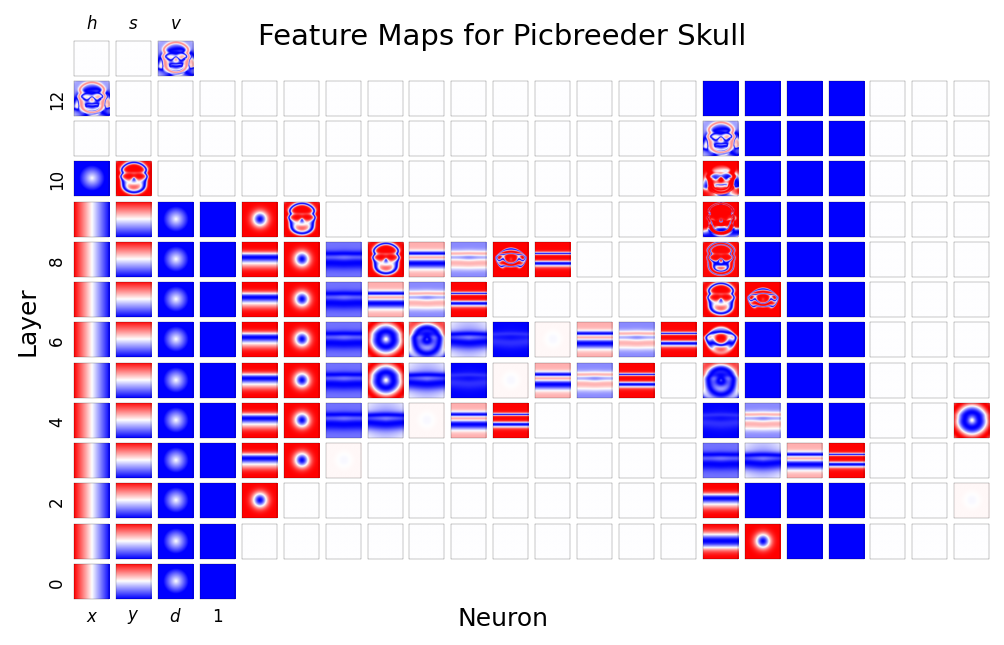

ParameterReshaper: 21604 parameters detected for optimization.


  0%|          | 0/14 [00:00<?, ?it/s]

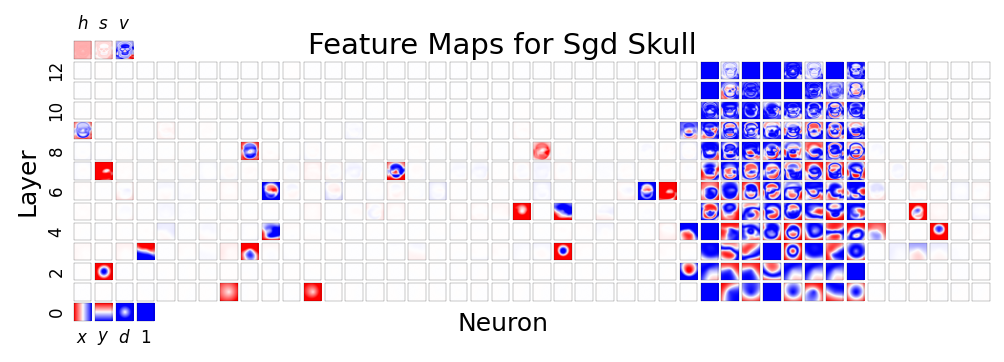

In [23]:
for genome in ["skull"]:
    for source in ["picbreeder", "sgd"]:
        save_dir = f"../data/{source}_{genome}"
        arch_ = util.load_pkl(save_dir, "arch")
        params = util.load_pkl(save_dir, "params")
        cppn = FlattenCPPNParameters(CPPN(arch_))
        img, features = cppn.generate_image(params, img_size=128, return_features=True)
        features = jax.tree.map(lambda x: np.array(x), features)
        fig = viz_feature_maps(features)
        plt.suptitle(f"Feature Maps for {source.capitalize()} {genome.capitalize()}", fontsize=14)
        plt.show()

Notice that although the Picbreeder and SGD CPPNs have the same output behavior, their internal representations are extremely different.
Picbreeder representation is **Unified and Factored** while the SGD representation is **Fractured and Entangled**.

# Weight Sweeps
Here, we will sweep individual weights across a suite of values to see how that single weight affects the output image.
Because the parameters of the network are flat vectors (thanks to FlattenCPPNParameters), this is pretty easy to do.

Feel free to play around with different weight sweeps yourself for the Picbreeder and SGD CPPNs!

In [12]:
def sweep_weight(params, weight_id, cppn, img_size=256, center_weight=None, r=1, n=5):
    """
    Sweeps a single weight across a range of values.
    params: the parameters of the network as a flat vector
    weight_id: the index of the weight to sweep
    cppn: the CPPN object
    img_size: the size of the image to generate
    center_weight: center the sweep around this weight value, None for original weight value
    r: the distance to sweep the weight (-r, r)
    n: the number of samples to take between -r and r
    """
    assert (center_weight is None) or isinstance(center_weight, float)
    weight_sweep = jnp.linspace(-r, r, n)
    if isinstance(center_weight, float):
        weight_sweep = weight_sweep + center_weight
    else:
        weight_sweep = weight_sweep + params[weight_id]
    params_p = repeat(params, "p -> n p", n=n).at[:, weight_id].set(weight_sweep)
    # imgs = gen_img_fn(params_p)
    imgs = jax.vmap(partial(cppn.generate_image, img_size=img_size))(params_p)
    return imgs

ParameterReshaper: 5478 parameters detected for optimization.


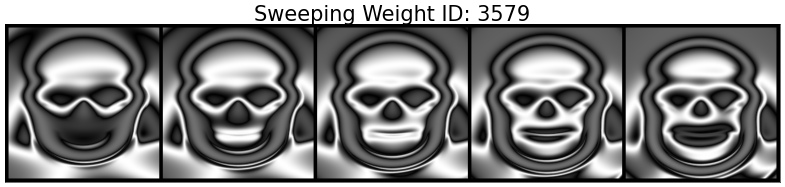

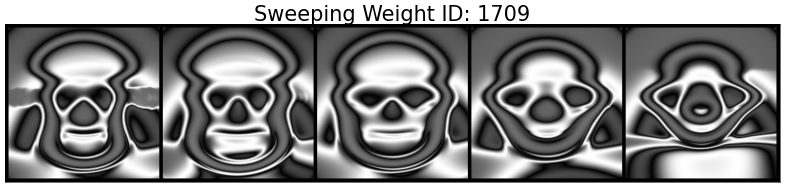

In [13]:
source, genome = "picbreeder", "skull" # changing source to "sgd" will sweep the SGD CPPNs, try it
save_dir = f"../data/{source}_{genome}"
arch_ = util.load_pkl(save_dir, "arch")
params = util.load_pkl(save_dir, "params")
cppn = FlattenCPPNParameters(CPPN(arch_))

sweep_weight_fn = partial(sweep_weight, cppn=cppn, img_size=256, center_weight=None, r=1, n=5)

padding = 6
for weight_id in [3579, 1709]:
    img = np.array(sweep_weight_fn(params, weight_id))
    img = np.pad(img, ((0, 0), (padding, 0), (padding, 0), (0, 0)), mode='constant', constant_values=0.)
    img = rearrange(img, "N H W D -> H (N W) D")
    img = np.pad(img, ((0, padding), (0, padding), (0, 0)), mode='constant', constant_values=0.)

    plt.figure(figsize=(20, 5), dpi=50)
    plt.imshow(img)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.title(f"Sweeping Weight ID: {weight_id}", fontsize=30)
    plt.show()


Here is the code to replicate the original sweeps from the paper.

In [14]:
weight_sweep_data = {}

weight_ids = [4371, 5009, 5097, 37]
descriptions = ["Controls Mouth Opening", "Controls Eye Winking", "Controls Eye Width", "Controls Jaw Width"]
weight_sweep_controls = [None, None, None, None]
weight_sweep_data[("picbreeder", "skull")] = dict(weight_ids=weight_ids, descriptions=descriptions, weight_sweep_controls=weight_sweep_controls)

weight_ids = [21500, 81, 19000, 15000]
descriptions = [" ", " ", " ", " "]
weight_sweep_controls = [None, None, None, None]
weight_sweep_data[("sgd", "skull")] = dict(weight_ids=weight_ids, descriptions=descriptions, weight_sweep_controls=weight_sweep_controls)

<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-967909770.py:34: SyntaxWarning: invalid escape sequence '\D'
  plt.xticks([img_size_p*0+img_size_p/2, img_size_p*2+img_size_p/2, img_size_p*4+img_size_p/2], ["$\Delta w = -$1", "$\Delta w = $0", "$\Delta w = +$1"], fontsize=25)
/tmp/ipython-input-967909770.py:34: SyntaxWarning: invalid escape sequence '\D'
  plt.xticks([img_size_p*0+img_size_p/2, img_size_p*2+img_size_p/2, img_size_p*4+img_size_p/2], ["$\Delta w = -$1", "$\Delta w = $0", "$\Delta w = +$1"], fontsize=25)
/tmp/ipython-input-967909770.py:34: SyntaxWarning: invalid escape sequence '\D'
  plt.xticks([img_size_p*0+img_size_p/2, img_size_p*2+img_size_p/2, img_size_p*4+img_size_p/2], ["$\Delta w = -$1", "$\D

ParameterReshaper: 5478 parameters detected for optimization.


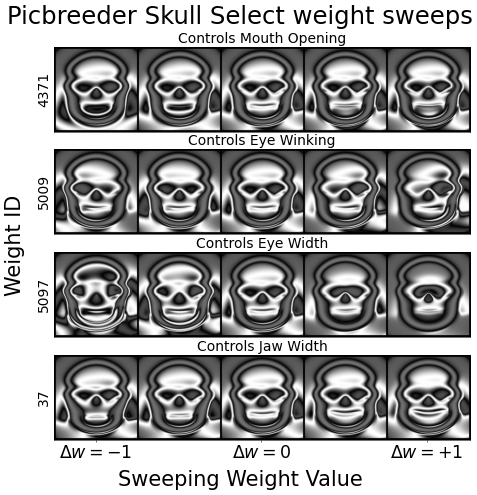

ParameterReshaper: 78204 parameters detected for optimization.


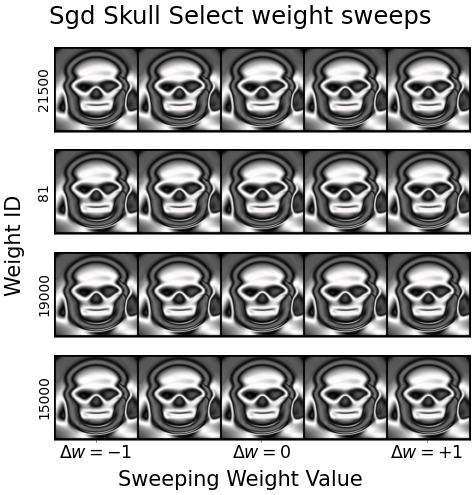

In [15]:
for genome in ["skull"]:
    for source in ["picbreeder", "sgd"]:
        save_dir = f"../data/{source}_{genome}"
        arch_ = util.load_pkl(save_dir, "arch")
        params = util.load_pkl(save_dir, "params")
        cppn = FlattenCPPNParameters(CPPN(arch_))
        # sweep_weight_fn = partial(sweep_weight_random_direction, cppn=cppn, img_size=64, center_weight=None, r=1, n=5, ret="imgs")

        data = weight_sweep_data[(source, genome)]

        fig, axs = plt.subplots(4, 1, figsize=(10, 10), dpi=50)
        padding = 6
        for iplt, (weight_id, controls, description) in enumerate(zip(data["weight_ids"], data["weight_sweep_controls"], data["descriptions"])):
            if controls is None:
                sweep_weight_fn = partial(sweep_weight, cppn=cppn, img_size=256, center_weight=None, r=1, n=5)
            else:
                c, r = controls
                sweep_weight_fn = partial(sweep_weight, cppn=cppn, img_size=256, center_weight=c, r=r, n=5)


            img = np.array(sweep_weight_fn(params, weight_id))

            img = np.pad(img, ((0, 0), (padding, 0), (padding, 0), (0, 0)), mode='constant', constant_values=0.)
            img = rearrange(img, "N H W D -> H (N W) D")
            img = np.pad(img, ((0, padding), (0, padding), (0, 0)), mode='constant', constant_values=0.)

            plt.sca(axs[iplt])
            plt.imshow(img)
            plt.xticks([]); plt.yticks([]); plt.grid(False)
            plt.title(f"{description}", fontsize=20)
            plt.ylabel(f"{weight_id}", fontsize=20)
            if iplt==3:
                img_size_p = 256+padding
                plt.xticks([img_size_p*0+img_size_p/2, img_size_p*2+img_size_p/2, img_size_p*4+img_size_p/2], ["$\Delta w = -$1", "$\Delta w = $0", "$\Delta w = +$1"], fontsize=25)

        plt.gcf().supylabel("Weight ID", fontsize=30, x=0.03)
        plt.gcf().supxlabel("Sweeping Weight Value", fontsize=30)
        plt.suptitle(f"{source.capitalize()} {genome.capitalize()} Select weight sweeps", fontsize=35)
        plt.tight_layout()
        # plt.savefig(f"/home/akarsh_sakana_ai/spaghetti-data/figures/weight_sweeps_{pid}_{arch}.pdf", format="pdf", bbox_inches="tight", dpi=300)
        # plt.close()
        plt.show()



Now let's do some sweeps which are agnostic to the basis of the feature's vector space, so we aren't assuming that the neuron basis is the only one that matters.
See paper appendix for more details.

In [16]:

def sweep_weight_random_direction(params, seed, cppn, img_size=256, center_weight=None, r=1, n=5):
    """
    Sweeps a column of the weight matrix in a random direction.
    The reason we do this is to create weight sweeps that are agnostic to any particular basis of the resulting feature's vector space.
    For more details, see the paper appendix.
    """
    assert (center_weight is None) or isinstance(center_weight, float)
    params = cppn.param_reshaper.reshape_single(params)
    layer_names = list(params['params'].keys())
    rng1, rng2 = jax.random.split(jax.random.PRNGKey(seed), 2)
    # layer_idx = jax.random.choice(rng1, len(layer_names)).item()
    # layer_name = layer_names[layer_idx]
    np.random.seed(seed)
    layer_name = np.random.choice(layer_names)
    n_rows, n_cols = params['params'][layer_name]['kernel'].shape
    i_row = jax.random.randint(rng1, (), 0, n_rows)
    e_i = jnp.eye(n_rows)[i_row]
    vec = jax.random.normal(rng2, (n_cols,))
    vec = vec/jnp.linalg.norm(vec)
    dW = e_i[:, None] @ vec[None, :]
    ts = jnp.linspace(-r, r, n)
    def gen_single_t(t):
        p = jax.tree.map(lambda x: x, params)
        p['params'][layer_name]['kernel'] = p['params'][layer_name]['kernel'] + t*dW
        p = cppn.param_reshaper.flatten_single(p)
        img = cppn.generate_image(p, img_size=img_size)
        return img
    imgs = jax.vmap(gen_single_t)(ts)
    return imgs


In [17]:
rand_weight_sweep_data = {}
for source in ["picbreeder", "sgd"]:
    for genome in ["skull"]:
        save_dir = f"../data/{source}_{genome}"
        arch_ = util.load_pkl(save_dir, "arch")
        params = util.load_pkl(save_dir, "params")
        cppn = FlattenCPPNParameters(CPPN(arch_))

        sweep_weight_fn = partial(sweep_weight_random_direction, cppn=cppn, img_size=64, center_weight=None, r=2, n=5)
        imgs = np.stack([sweep_weight_fn(params, seed) for seed in tqdm(range(200))])
        imgs = imgs[imgs.var(axis=1).mean(axis=(-1, -2, -3)).argsort()[::-1]] # sort by highest to lowest variance
        rand_weight_sweep_data[(source, genome)] = imgs

ParameterReshaper: 5478 parameters detected for optimization.


  0%|          | 0/200 [00:00<?, ?it/s]

ParameterReshaper: 78204 parameters detected for optimization.


  0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
for genome in ['skull']:
    for source in ['picbreeder', 'sgd']:
        plt.figure(figsize=(20, 16), dpi=50)
        for i in range(60):
            img = rand_weight_sweep_data[(source, genome)][i]
            img = rearrange(img, "T H W D -> H (T W) D")
            plt.subplot(15, 4, i+1)
            plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.grid(False)
            for spine in plt.gca().spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1)
        plt.suptitle(f"{source.capitalize()} {genome.capitalize()} Weight Sweeps", fontsize=20, y=0.99)
        plt.tight_layout()
        plt.show()

Output hidden; open in https://colab.research.google.com to view.